### **Analisis Prediktif: Prediksi Harga Smartphone Untuk Menghindari Penipuan**

*oleh : Indah Dwi Sulistiyawati*

*Proyek Submission 1 - Machine Learning Terapan Dicoding*

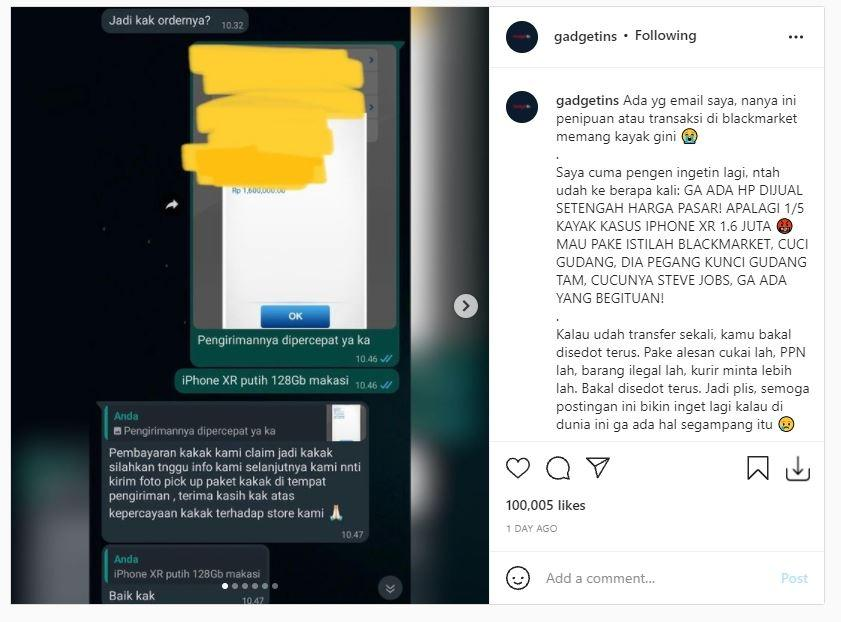

# Pendahuluan

Pada proyek ini, topik yang dibahas adalah mengenai bidang ekonomi dan bisnis yang di buat untuk mengetahui prediksi harga smartphone untuk mencegah penipuan. Proyek ini dibuat untuk proyek Submission 1 - Machine Learning Terapan Dicoding.

# **1. Import library yang dibutuhkan**

In [1]:
# update modul python terbaru
!pip install -U scikit-learn
!pip install -q kaggle

In [2]:
# untuk proses pengolahan data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# untuk pembuatan model
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV

# untuk evaluasi model
from sklearn.metrics import confusion_matrix, classification_report

# **2. Mempersiapkan Dataset**

## 2.1 Menyiapkan kredensial akun Kaggle

In [3]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


## 2.2 Mengunduh dan Menyiapkan Dataset

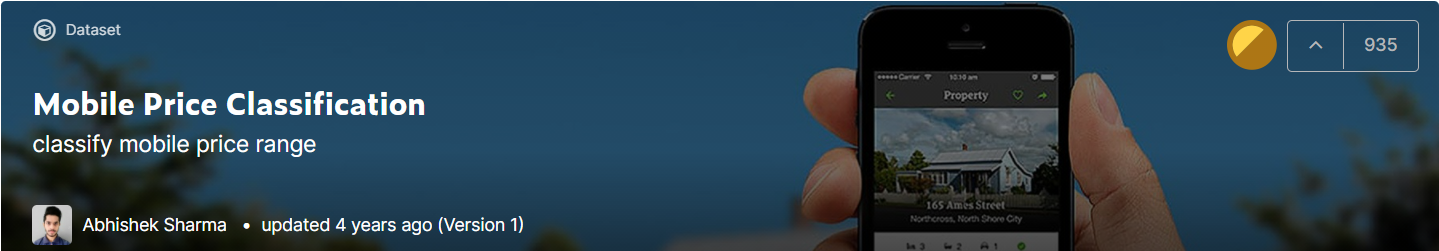

sumber dataset : https://www.kaggle.com/iabhishekofficial/mobile-price-classification

In [4]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download iabhishekofficial/mobile-price-classification

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [5]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!unzip /content/mobile-price-classification.zip

Archive:  /content/mobile-price-classification.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


# **3. Pemahaman Data (Data Understanding)**

## 3.1 Memuat Data pada sebuah Dataframe menggunakan pandas

In [6]:
#akan dimuat data dan dilihat 5 data teratas
df = pd.read_csv("/content/train.csv")
df.head()

battery_power  blue  clock_speed  ...  touch_screen  wifi  price_range
0            842     0          2.2  ...             0     1            1
1           1021     1          0.5  ...             1     0            2
2            563     1          0.5  ...             1     0            2
3            615     1          2.5  ...             0     0            2
4           1821     1          1.2  ...             1     0            1

[5 rows x 21 columns]

## 3.2 *Exploratory Data Analysis* (EDA)

## 3.2.1 Deskripsi Variabel

In [7]:
df.columns = [column.lower() for column in df.columns]
print("Total:", df.shape[0], end="\n\n")
df.info()

Total: 2000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  


Selanjutnya akan diubah data numerik menjadi data kategori untuk mempermudah dalam analisis selanjutnya

In [8]:
# Variabel Independen
df.blue.replace(0,'No', inplace=True)
df.blue.replace(1,'Yes', inplace=True)
df.dual_sim.replace(0,'No', inplace=True)
df.dual_sim.replace(1,'Yes', inplace=True)
df.four_g.replace(0,'No', inplace=True)
df.four_g.replace(1,'Yes', inplace=True)
df.three_g.replace(0,'No', inplace=True)
df.three_g.replace(1,'Yes', inplace=True)
df.touch_screen.replace(0,'No', inplace=True)
df.touch_screen.replace(1,'Yes', inplace=True)
df.wifi.replace(0,'No', inplace=True)
df.wifi.replace(1,'Yes', inplace=True)

# Variabel Dependent --> Dalam hal ini variabel dependent merupakan variabel target 
df.price_range.replace(0,'low cost', inplace=True)
df.price_range.replace(1,'medium cost', inplace=True)
df.price_range.replace(2,'high cost', inplace=True)
df.price_range.replace(3,'very high cost', inplace=True)

Mari kita lihat informasi yang termuat pada dataset

In [9]:
def report(df):
  col = []
  d_type = []
  uniques = []
  n_uniques = []

  for i in df.columns:
    col.append(i) # Nama Column
    d_type.append(df[i].dtypes) # Tipe Data
    uniques.append(df[i].unique()[:5]) # Elemen pada variabel
    n_uniques.append(df[i].nunique()) # Jumlah elemen pada variabel

  return pd.DataFrame({'Column': col, 'd_type':d_type, 'unique_sample':uniques, 'n_unique_sample':n_uniques})

In [10]:
report(df)

Column  ... n_unique_sample
0   battery_power  ...            1094
1            blue  ...               2
2     clock_speed  ...              26
3        dual_sim  ...               2
4              fc  ...              20
5          four_g  ...               2
6      int_memory  ...              63
7           m_dep  ...              10
8       mobile_wt  ...             121
9         n_cores  ...               8
10             pc  ...              21
11      px_height  ...            1137
12       px_width  ...            1109
13            ram  ...            1562
14           sc_h  ...              15
15           sc_w  ...              19
16      talk_time  ...              19
17        three_g  ...               2
18   touch_screen  ...               2
19           wifi  ...               2
20    price_range  ...               4

[21 rows x 4 columns]

## 3.2.2 Deskripsi Statistik

In [11]:
df.describe()

battery_power  clock_speed  ...         sc_w    talk_time
count    2000.000000  2000.000000  ...  2000.000000  2000.000000
mean     1238.518500     1.522250  ...     5.767000    11.011000
std       439.418206     0.816004  ...     4.356398     5.463955
min       501.000000     0.500000  ...     0.000000     2.000000
25%       851.750000     0.700000  ...     2.000000     6.000000
50%      1226.000000     1.500000  ...     5.000000    11.000000
75%      1615.250000     2.200000  ...     9.000000    16.000000
max      1998.000000     3.000000  ...    18.000000    20.000000

[8 rows x 14 columns]

## 3.2.3 Menghapus data yang bernilai sama

In [12]:
print("Total data sebelum dihapus:", df.shape[0])
df = df.drop_duplicates()
print("Total data sesudah dihapus:", df.shape[0])

Total data sebelum dihapus: 2000
Total data sesudah dihapus: 2000


## 3.2.4 Menangani Missing Value

In [13]:
df.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

Selanjutnya kita cek apakah ada data yang duplikat atau tidak

In [14]:
df.duplicated().sum()

0

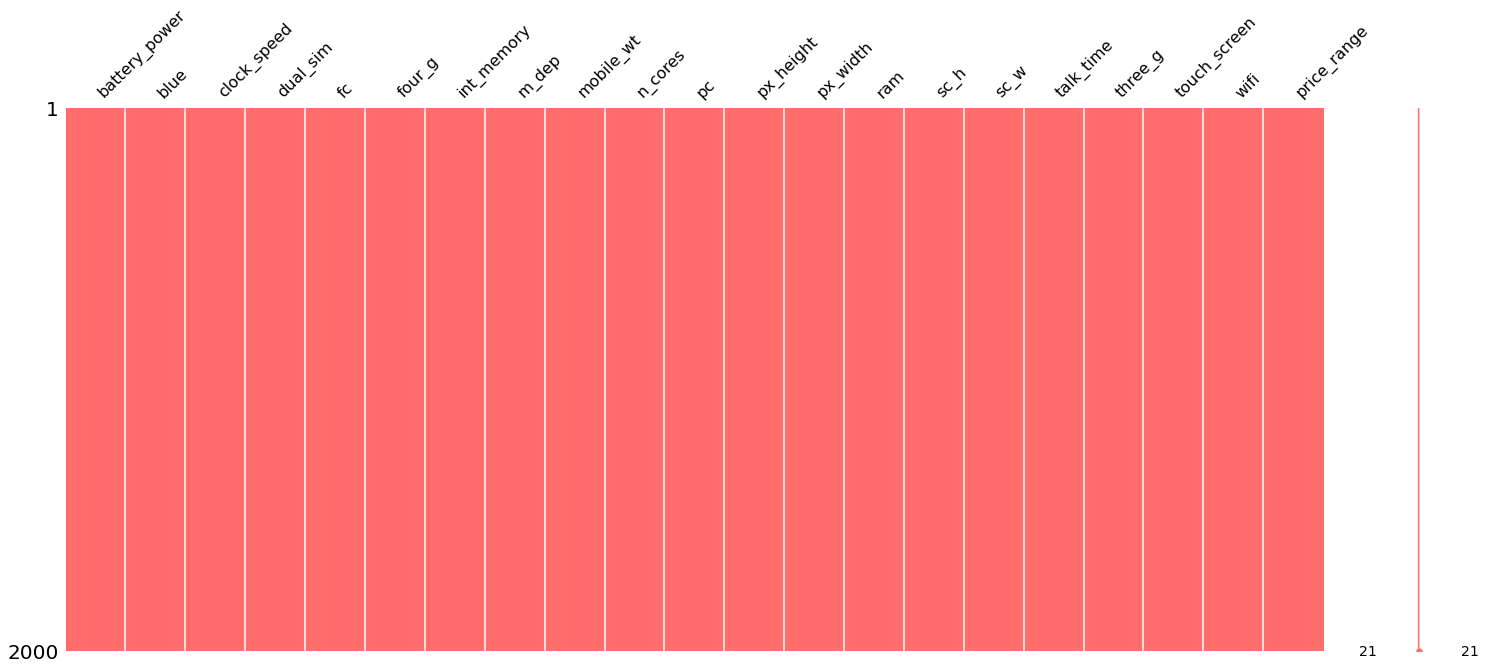

In [15]:
# Melakukan visualisasi data yang kosong
import missingno as msno
sorted_null = msno.nullity_sort(df, sort='descending') 
figures = msno.matrix(sorted_null, color=(1, 0.43, 0.43))

Dapat dilihat bahwa dalam data tersebut tidak terdapat missing value dan data duplikat.

## 3.2.5 Analisis Univariat


Hal pertama yang dilakukan adalah membagi fitur pada dataset menjadi bagian numerical features dan bagian categorical features.

In [16]:
cat_features = df.loc[:, df.dtypes == 'object'].columns.to_list()
num_features = df.loc[:, df.dtypes != 'object'].columns.to_list()

Analisa Pada Categorical Features

     Total   Persentase
No     1010        50.5
Yes     990        49.5



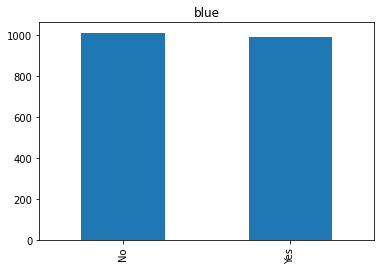

     Total   Persentase
Yes    1019        50.9
No      981        49.0



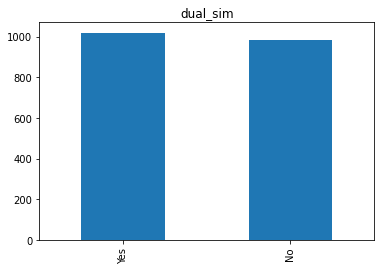

     Total   Persentase
Yes    1043        52.2
No      957        47.8



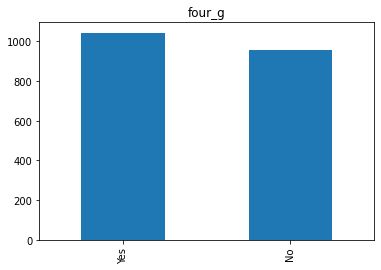

     Total   Persentase
Yes    1523        76.1
No      477        23.8



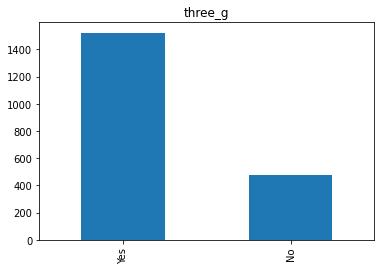

     Total   Persentase
Yes    1006        50.3
No      994        49.7



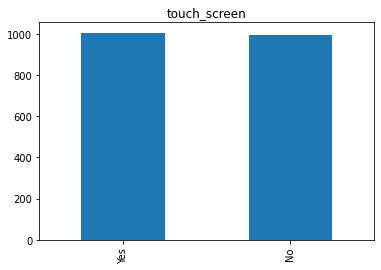

     Total   Persentase
Yes    1014        50.7
No      986        49.3



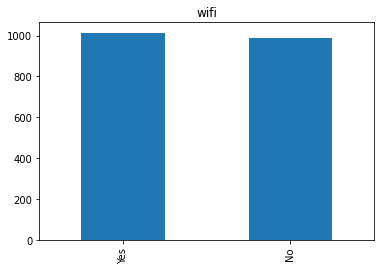

                Total   Persentase
low cost           500        25.0
medium cost        500        25.0
very high cost     500        25.0
high cost          500        25.0



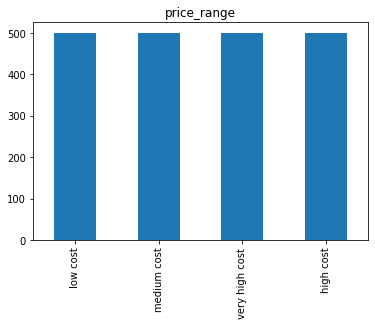

In [17]:
cat_features = ["blue", "dual_sim", "four_g", 
                      "three_g", "touch_screen", 
                      "wifi", "price_range"]

for column in cat_features:
    count = df[column].value_counts()
    percent = 100*df[column].value_counts(normalize=True)
    data_baru = pd.DataFrame({'Total ':count, 'Persentase':percent.round(1)})
    print(data_baru, end="\n\n")
    count.plot(kind='bar', title=column)
    plt.show()

Analisa Pada Numerical Features

Sebelumnya mari kita lihat outlier pada numeric features

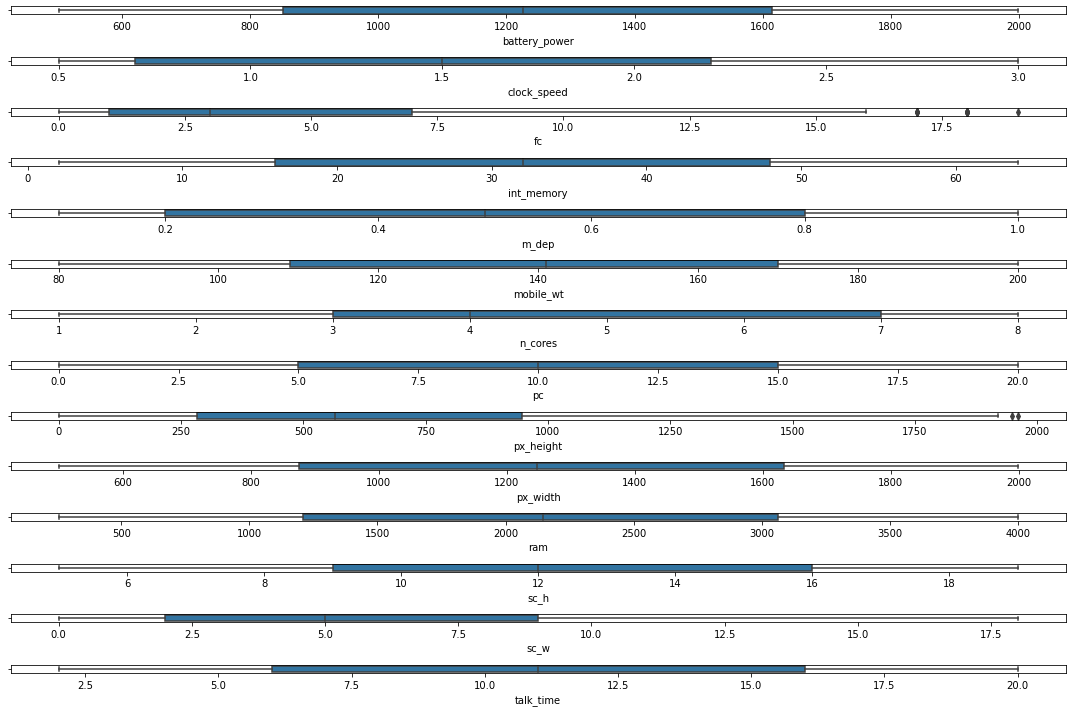

In [18]:
fig, axs = plt.subplots(len(num_features), figsize= (15,10))
i=0
for feature in num_features:
  sns.boxplot(df[feature], ax=axs[i])
  i+=1
  plt.tight_layout()
plt.show()

Dari plot diatas terdapat outlier pada 'fc' namun masih dalam kategori aman. Selanjutnya mari kita analisa numeric features

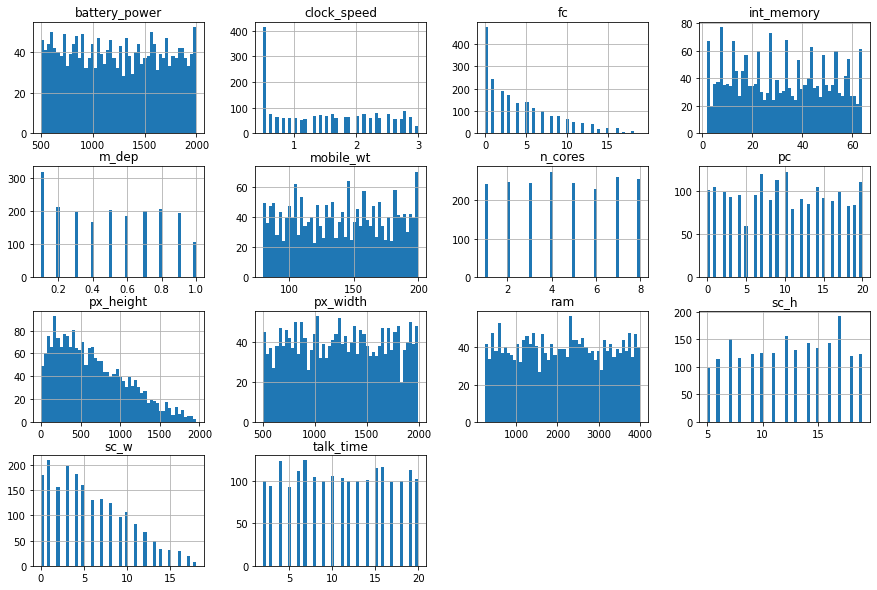

In [19]:
df.hist(bins=50, figsize=(15,10))
plt.show()

## 3.2.6 Analisis Multivariat

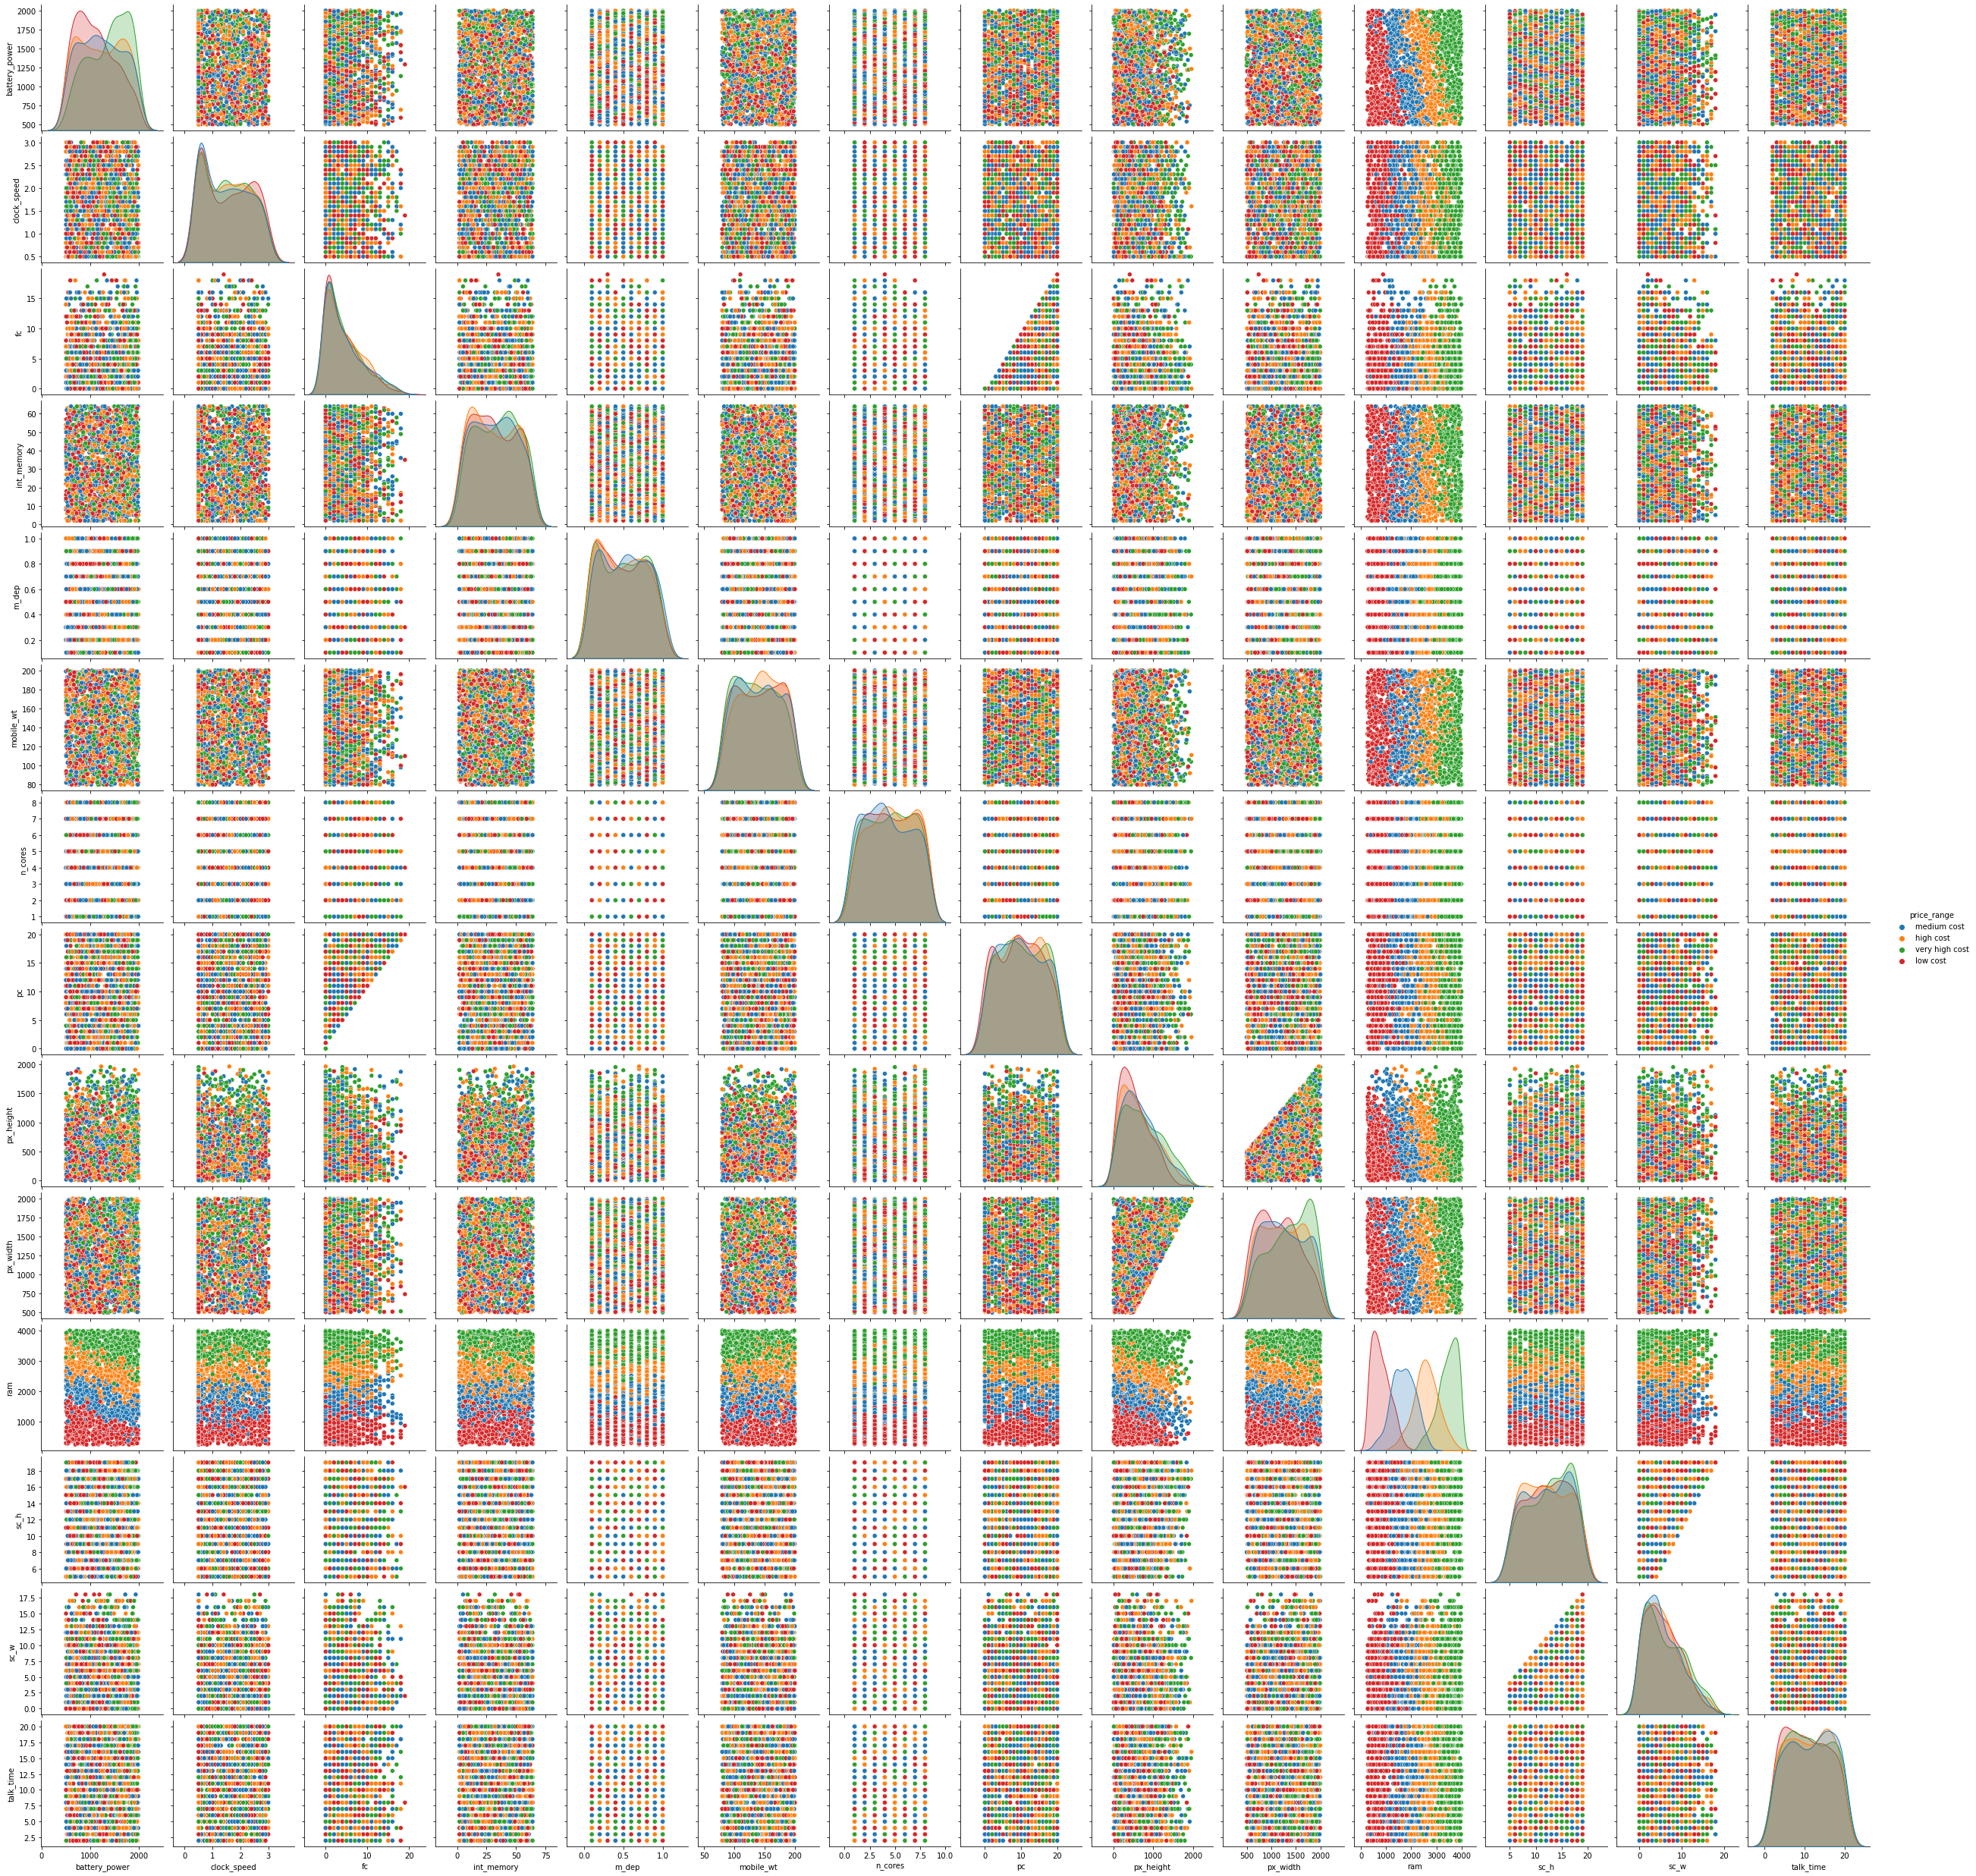

In [20]:
# Visualisasi distribusi data pada kolom dengan numeric features dan antar numeric features
# hue untuk memisahkan sesuai dengan variabel target 
# kde di diag_kind untuk untuk melihat perkiraan distribusi probabilitas dapat mneggunakan
sns.pairplot(df,  diag_kind = 'kde', hue='price_range')

## 3.2.7 Cek Korelasi

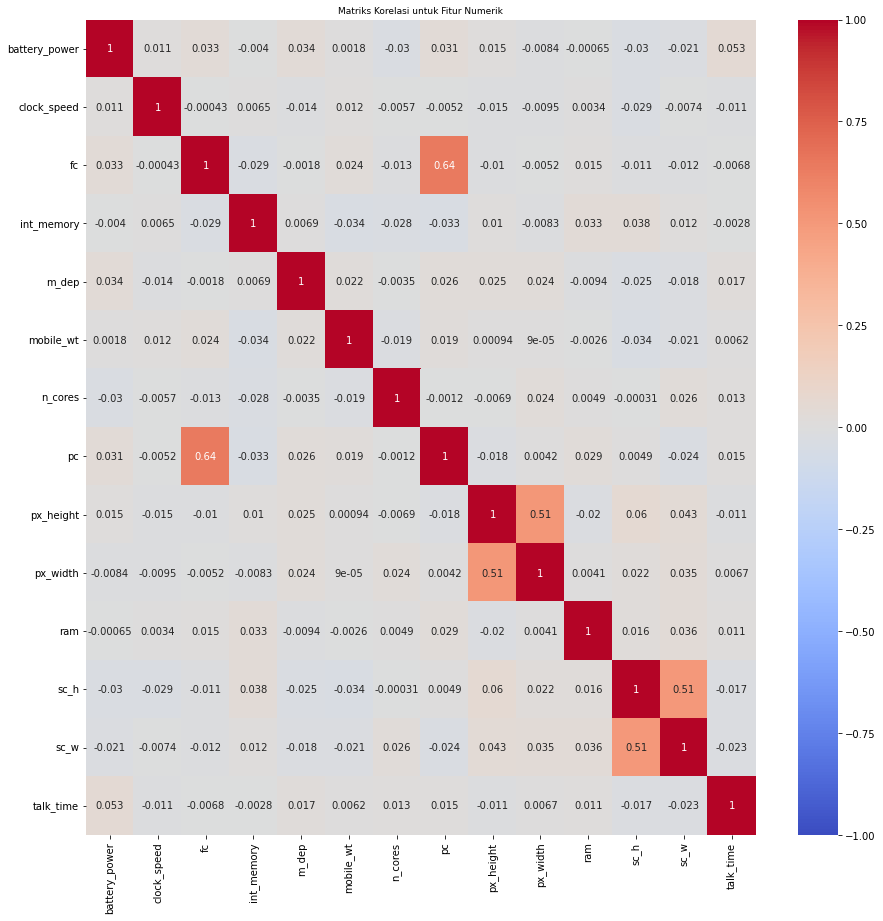

In [21]:
plt.figure(figsize=(15,15))
plt.title('Matriks Korelasi untuk Fitur Numerik', fontsize=9)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

# **4. Persiapan Data (Data Preparation)**

## 4.1 Encoding Fitur Kategori (Categorical Encoding)



*   Categorical Encoding adalah proses mengubah data kategori menjadi data numerik
*   One-Hot Encoding dilakukan pada data nominal dimana data nominal akan diklasifikasikan tanpa urutan atau peringkat



In [22]:
# Encoding tanpa variabel dependent sebagai variabel target
df = pd.get_dummies(df, columns=df.loc[:, (df.dtypes == 'object') & (df.columns != 'price_range')].columns.to_list())

In [23]:
# Encoding manual dengan memasukan varibel dependet sebagai variabel target
df.price_range.replace('low cost', 0, inplace=True)
df.price_range.replace('medium cost', 1, inplace=True)
df.price_range.replace('high cost', 2, inplace=True)
df.price_range.replace('very high cost', 3, inplace=True)

In [24]:
# tampilkan data
df

battery_power  clock_speed  fc  ...  touch_screen_Yes  wifi_No  wifi_Yes
0               842          2.2   1  ...                 0        0         1
1              1021          0.5   0  ...                 1        1         0
2               563          0.5   2  ...                 1        1         0
3               615          2.5   0  ...                 0        1         0
4              1821          1.2  13  ...                 1        1         0
...             ...          ...  ..  ...               ...      ...       ...
1995            794          0.5   0  ...                 1        1         0
1996           1965          2.6   0  ...                 1        0         1
1997           1911          0.9   1  ...                 1        1         0
1998           1512          0.9   4  ...                 1        0         1
1999            510          2.0   5  ...                 1        0         1

[2000 rows x 27 columns]

## 4.2 Split Data

Data akan di split dengan train_test_split menjadi data train dan data test

In [25]:
X = df.drop('price_range', axis=1).values
y = df['price_range'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y)

print(f'Total seluruh sampel: {len(X)}')
print(f'Total data train: {len(X_train)}')
print(f'Total data test: {len(X_test)}')

Total seluruh sampel: 2000
Total data train: 1600
Total data test: 400


## 4.3 Standarisasi nilai pada numeric features dengan StandardScaler

In [26]:
all_columns = df.columns[:-1]
scaler = StandardScaler()
df[all_columns] = scaler.fit_transform(df[all_columns])
df.head()

battery_power  clock_speed        fc  ...  touch_screen_Yes   wifi_No  wifi_Yes
0      -0.902597     0.830779 -0.762495  ...         -1.006018 -0.986097         1
1      -0.495139    -1.253064 -0.992890  ...          0.994018  1.014099         0
2      -1.537686    -1.253064 -0.532099  ...          0.994018  1.014099         0
3      -1.419319     1.198517 -0.992890  ...         -1.006018  1.014099         0
4       1.325906    -0.395011  2.002254  ...          0.994018  1.014099         0

[5 rows x 27 columns]

# **5. Pembuatan Model**

Dalam hal ini akan digunakan model Support Vector Machine (SVM) dan Hyper Parameter Tuning dari model Support Vector Machine (SVM) sebagai acuan dalam menemukan parameter terbaik.

## 5.1 Model Baseline dengan SVM

In [27]:
# Pembuatan model baseline
baseline_model = SVC()

# Melakukan training
baseline_model.fit(X_train, y_train)

SVC()

In [28]:
# Uji model terhadap data test
y_pred = baseline_model.predict(X_test)

In [29]:
# report klasifikasi untuk model baseline
cr_baseline = classification_report(y_test, y_pred, output_dict=True, target_names=['low cost', 'medium cost', 'high cost', 'very high cost'])
pd.DataFrame(cr_baseline).T

precision  recall  f1-score   support
low cost         0.980392  1.0000  0.990099  100.0000
medium cost      0.950980  0.9700  0.960396  100.0000
high cost        0.967742  0.9000  0.932642  100.0000
very high cost   0.951456  0.9800  0.965517  100.0000
accuracy         0.962500  0.9625  0.962500    0.9625
macro avg        0.962643  0.9625  0.962164  400.0000
weighted avg     0.962643  0.9625  0.962164  400.0000

In [30]:
# confusion matrix model baseline
cf_baseline = confusion_matrix(y_test, y_pred)

## 5.2 Pengembangan Model Support Vector Machine (SVM) menggunakan Hyper Parameter Tuning dengaan GridSearchCV

In [31]:
# hyperparameter yang akan di tuning
parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf'] 
}

In [32]:
# Menetapkan StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pembuatan model untuk GridSearchCV
grid = GridSearchCV(baseline_model, parameters, cv=skf, verbose=1, scoring='accuracy', n_jobs=-1)

# Melakukan Training
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [33]:
print("Best parameter: ", grid.best_estimator_)
print("Score: ", grid.best_score_)

Best parameter:  SVC(C=10, gamma=0.0001)
Score:  0.760625


In [34]:
# Pembuatan model best parameter
best_model = grid.best_estimator_

# Melakukan training
best_model.fit(X_train, y_train)

SVC(C=10, gamma=0.0001)

In [35]:
# Pengujian model terhadap data test
y_pred = best_model.predict(X_test)

In [36]:
# classification report model best parameter
cr_best = classification_report(y_test, y_pred, output_dict=True, target_names=['low cost', 'medium cost', 'high cost', 'very high cost'])
pd.DataFrame(cr_best).T

precision  recall  f1-score   support
low cost         0.978723  0.9200  0.948454  100.0000
medium cost      0.948718  0.7400  0.831461  100.0000
high cost        0.891566  0.7400  0.808743  100.0000
very high cost   0.655172  0.9500  0.775510  100.0000
accuracy         0.837500  0.8375  0.837500    0.8375
macro avg        0.868545  0.8375  0.841042  400.0000
weighted avg     0.868545  0.8375  0.841042  400.0000

In [37]:
# confusion matrix untuk model best parameter
cf_best = confusion_matrix(y_test, y_pred)

# **6. Evaluasi Model**

## 6.1 Perbandingan matrix model baseline dengan model yang dikembangkan

In [38]:
print("Classification Report untuk Model Baseline")
pd.DataFrame(cr_baseline).T

Classification Report untuk Model Baseline


precision  recall  f1-score   support
low cost         0.980392  1.0000  0.990099  100.0000
medium cost      0.950980  0.9700  0.960396  100.0000
high cost        0.967742  0.9000  0.932642  100.0000
very high cost   0.951456  0.9800  0.965517  100.0000
accuracy         0.962500  0.9625  0.962500    0.9625
macro avg        0.962643  0.9625  0.962164  400.0000
weighted avg     0.962643  0.9625  0.962164  400.0000

In [39]:
print("Classification Report Model untuk Parameter Terbaik")
pd.DataFrame(cr_best).T

Classification Report Model untuk Parameter Terbaik


precision  recall  f1-score   support
low cost         0.978723  0.9200  0.948454  100.0000
medium cost      0.948718  0.7400  0.831461  100.0000
high cost        0.891566  0.7400  0.808743  100.0000
very high cost   0.655172  0.9500  0.775510  100.0000
accuracy         0.837500  0.8375  0.837500    0.8375
macro avg        0.868545  0.8375  0.841042  400.0000
weighted avg     0.868545  0.8375  0.841042  400.0000

## 6.2 Perbandingan confusion matriks untuk model baseline dan model yang dikembangkan

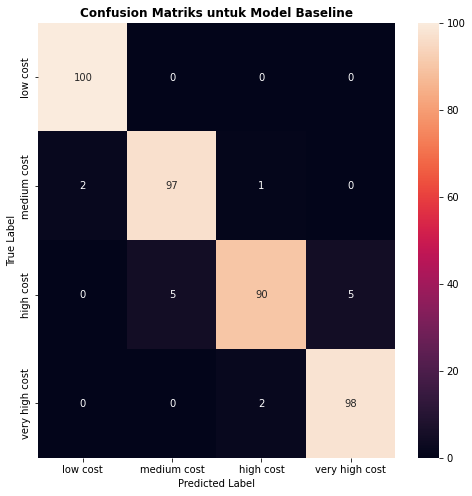

In [40]:
# Visualisasi hasil prediksi model baseline
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(cf_baseline, annot=True, fmt='g')

ax.set_yticklabels(['low cost', 'medium cost', 'high cost', 'very high cost'])
ax.set_xticklabels(['low cost', 'medium cost', 'high cost', 'very high cost'])

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

ax.set_title('Confusion Matriks untuk Model Baseline', fontweight='bold')
plt.show()

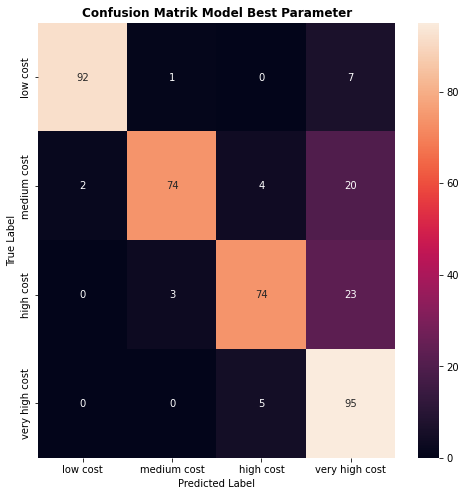

In [41]:
# Visualisasi hasil prediksi model untuk best parameter
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(cf_best, annot=True, fmt='g')

ax.set_yticklabels(['low cost', 'medium cost', 'high cost', 'very high cost'])
ax.set_xticklabels(['low cost', 'medium cost', 'high cost', 'very high cost'])

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

ax.set_title('Confusion Matrik Model Best Parameter', fontweight='bold')
plt.show()

Kesimpulan : Model yang digunakan untuk memprediksi harga smartphone agar terhindar dari penipuan telah selesai dibuat. Tingkat akurasi yang dihasilkan sudah tinggi dengan mengimplementasikan model SVM.